# Training HOG-based AU detectors
*written by Tiankang Xie*  

In the tutorial we will demonstrate how to train the HOG-based AU models as described in our paper. 
The tutorial is split into 3 parts, where the first part demonstrates how to extract hog features from the dataset,
and the second part demonstrates how to use the extracted hogs to perform statistical learning, the third part will be
to demonstrate how to test the trained models with additional test data

## Part 1: Extracting HOGs and Landmarks

In [42]:
from PIL import Image, ImageOps
import math
from scipy.spatial import ConvexHull
from skimage.morphology.convex_hull import grid_points_in_poly
from feat import Detector
from feat.tests.utils import get_test_data_path
import os
import matplotlib.pyplot as plt
## EXTRACT HOGS
from skimage import data, exposure
from skimage.feature import hog
from tqdm import tqdm
import cv2
import pandas as pd
import csv
import numpy as np

def align_face_68pts(img, img_land, box_enlarge, img_size=112):
    """
    Adapted from https://github.com/ZhiwenShao/PyTorch-JAANet by Zhiwen Shao, modified by Tiankang Xie
    img: image
    img_land: landmarks 68
    box_enlarge: relative size of face
    img_size = 112
    """

    leftEye0 = (img_land[2 * 36] + img_land[2 * 37] + img_land[2 * 38] + img_land[2 * 39] + img_land[2 * 40] +
                img_land[2 * 41]) / 6.0
    leftEye1 = (img_land[2 * 36 + 1] + img_land[2 * 37 + 1] + img_land[2 * 38 + 1] + img_land[2 * 39 + 1] +
                img_land[2 * 40 + 1] + img_land[2 * 41 + 1]) / 6.0
    rightEye0 = (img_land[2 * 42] + img_land[2 * 43] + img_land[2 * 44] + img_land[2 * 45] + img_land[2 * 46] +
                 img_land[2 * 47]) / 6.0
    rightEye1 = (img_land[2 * 42 + 1] + img_land[2 * 43 + 1] + img_land[2 * 44 + 1] + img_land[2 * 45 + 1] +
                 img_land[2 * 46 + 1] + img_land[2 * 47 + 1]) / 6.0
    deltaX = (rightEye0 - leftEye0)
    deltaY = (rightEye1 - leftEye1)
    l = math.sqrt(deltaX * deltaX + deltaY * deltaY)
    sinVal = deltaY / l
    cosVal = deltaX / l
    mat1 = np.mat([[cosVal, sinVal, 0], [-sinVal, cosVal, 0], [0, 0, 1]])
    mat2 = np.mat([[leftEye0, leftEye1, 1], [rightEye0, rightEye1, 1], [img_land[2 * 30], img_land[2 * 30 + 1], 1],
                   [img_land[2 * 48], img_land[2 * 48 + 1], 1], [img_land[2 * 54], img_land[2 * 54 + 1], 1]])
    mat2 = (mat1 * mat2.T).T
    cx = float((max(mat2[:, 0]) + min(mat2[:, 0]))) * 0.5
    cy = float((max(mat2[:, 1]) + min(mat2[:, 1]))) * 0.5
    if (float(max(mat2[:, 0]) - min(mat2[:, 0])) > float(max(mat2[:, 1]) - min(mat2[:, 1]))):
        halfSize = 0.5 * box_enlarge * float((max(mat2[:, 0]) - min(mat2[:, 0])))
    else:
        halfSize = 0.5 * box_enlarge * float((max(mat2[:, 1]) - min(mat2[:, 1])))
    scale = (img_size - 1) / 2.0 / halfSize
    mat3 = np.mat([[scale, 0, scale * (halfSize - cx)], [0, scale, scale * (halfSize - cy)], [0, 0, 1]])
    mat = mat3 * mat1
    aligned_img = cv2.warpAffine(img, mat[0:2, :], (img_size, img_size), cv2.INTER_LINEAR, borderValue=(128, 128, 128))
    land_3d = np.ones((int(len(img_land)/2), 3))
    land_3d[:, 0:2] = np.reshape(np.array(img_land), (int(len(img_land)/2), 2))
    mat_land_3d = np.mat(land_3d)
    new_land = np.array((mat * mat_land_3d.T).T)
    new_land = np.array(list(zip(new_land[:,0], new_land[:,1]))).astype(int)
    return aligned_img, new_land


def extract_hog(image, detector):
    im = cv2.imread(image)
    detected_faces = np.array(detector.detect_faces(im)[0])
    im = np.asarray(im)
    detected_faces = np.array(detector.detect_faces(np.array(im))[0])
    detected_faces = detected_faces.astype(int)
    points = detector.detect_landmarks(np.array(im), [detected_faces])[0].astype(int)

    aligned_img, points = align_face_68pts(im, points.flatten(), 2.5)

    hull = ConvexHull(points)
    mask = grid_points_in_poly(shape=np.array(aligned_img).shape, 
                               verts= list(zip(points[hull.vertices][:,1], points[hull.vertices][:,0])) # for some reason verts need to be flipped
                               )
    mask[0:np.min([points[0][1], points[16][1]]), points[0][0]:points[16][0]] = True
    aligned_img[~mask] = 0
    resized_face_np = aligned_img

    fd, hog_image = hog(resized_face_np, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

    return fd, points.flatten(), resized_face_np, hog_image

# Initialize a detector class to detect landmarks and bounding box
A01 = Detector(face_model='RetinaFace',emotion_model=None, landmark_model="mobilenet", au_model=None) #initialize model

master_file = pd.read_csv("/home/tiankang/AU_Dataset/DISFA/toy_disfa.csv",index_col=0)
print(master_file)
# Make sure that in the master file you have a column (called original_path), which points to the path of the images

Loading Face Detection model:  RetinaFace
Loading Face Landmark model:  mobilenet
Loading au occurence model:  None
Loading emotion model:  None
                                        original_path  AU1  AU2  AU4  AU6  \
0   /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0   
1   /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0   
2   /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0   
3   /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    1    1    0    0   
4   /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    1    1    0    0   
5   /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    1    1    0    0   
6   /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    1    1    0    0   
7   /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    1    1    0    0   
8   /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    1    0    1    1   
9   /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    1    0    1    1   
10  /hom

100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


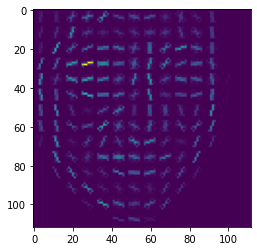

In [43]:
write_path = "/home/tiankang/AU_Dataset/OpenFace/tutorial" # This is the path where you store all hog and landmark files
master_file["Marked"] = True # THis mark column serves to check whether each image can be correctly processed by the algorithm.

with open(write_path+'hogs_file.csv', "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(list(range(5408)))

with open(write_path+'new_landmarks_files.csv', "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(list(range(136)))

for ix in tqdm(range(master_file.shape[0])):
    try:
        imageURL = master_file['original_path'][ix]
        fd, landpts, cropped_img, hogs = extract_hog(imageURL, detector=A01)
        with open(write_path+'hogs_file.csv', "a+", newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            writer.writerow(fd)
        
        with open(write_path+'new_landmarks_files.csv', "a+", newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            writer.writerow(landpts.flatten())
        
    except:
        master_file['Marked'][ix] = False
        print("failed to load",imageURL)
        continue;

# Try to visualize one subject
plt.imshow(hogs)
plt.show()
# Save the master file
master_file.to_csv(write_path+"HOG_master_file.csv")

## Part 2: Train Models with Hog

In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tqdm import tqdm 
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

In [45]:
# Load in y labels from the stored master file
master_file_hog = pd.read_csv(write_path+"HOG_master_file.csv", index_col=0)
master_file_hog = master_file_hog[master_file_hog['Marked']==True]
master_file_hog.reset_index(drop=True,inplace=True)
print(master_file_hog.head()) 

# We see that there are 9 possible AUs
AU_nums = [1,2,4,6,9,12,17,25,26]
AU_LABELS = ['AU'+str(i) for i in AU_nums]

master_ylabels = master_file_hog[AU_LABELS]
print(master_ylabels)

                                       original_path  AU1  AU2  AU4  AU6  AU9  \
0  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0    0   
1  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0    0   
2  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0    0   
3  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    1    1    0    0    0   
4  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    1    1    0    0    0   

   AU12  AU17  AU25  AU26  Marked  
0     0     0     0     0    True  
1     0     1     0     0    True  
2     0     0     0     0    True  
3     0     0     1     1    True  
4     1     0     1     1    True  
    AU1  AU2  AU4  AU6  AU9  AU12  AU17  AU25  AU26
0     0    0    0    0    0     0     0     0     0
1     0    0    0    0    0     0     1     0     0
2     0    0    0    0    0     0     0     0     0
3     1    1    0    0    0     0     0     1     1
4     1    1    0    0    0     1    

In [46]:
# Load in hogs and landmarks
hogs_vals = pd.read_csv(write_path+"hogs_file.csv")
landmarks_ts = pd.read_csv(write_path+"new_landmarks_files.csv")
print(hogs_vals.shape)
print(landmarks_ts.shape)

(15, 5408)
(15, 136)


In [47]:
# Perform PCA on the hogs and concatenate it with landmarks
scaler = StandardScaler()
hogs_cbd_std = scaler.fit_transform(hogs_vals)
pca = PCA(n_components = 0.95, svd_solver = 'full')
hogs_transformed = pca.fit_transform(hogs_cbd_std)
x_features = np.concatenate((hogs_transformed,landmarks_ts),1)
print(x_features.shape)

(15, 148)


In [48]:
# Train a classifier
def balanced_sample_maker(X, y, sample_size, random_seed=None):
    """ return a balanced data set by sampling all classes with sample_size 
        current version is developed on assumption that the positive
        class is the minority.

    Parameters:
    ===========
    X: {numpy.ndarrray}
    y: {numpy.ndarray}
    """
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    return (X[balanced_copy_idx, :], y[balanced_copy_idx], balanced_copy_idx)
    
def _return_SVM(hog_feature_cbd, y):
    (balX, baly, idx) = balanced_sample_maker(hog_feature_cbd, y, sample_size = np.sum(y==1), random_seed=1)
    # Scale HOG features
    #balXstd = scaler.fit_transform(balX)
    balXstd = balX
    #     Fit model
    clf = LinearSVC(C = 1e-6, max_iter=1200) # Change parameter here
    clf.fit(X=balXstd, y=baly)
    print("Training report:", classification_report(baly, clf.predict(balXstd)))
    return(clf)

def _return_RF(hog_feature_cbd,y):
    #print(np.isnan(hog_feature_cbd).sum())
    (balX, baly, idx) = balanced_sample_maker(hog_feature_cbd, y, sample_size = np.sum(y==1), random_seed=1)
    balXstd = balX
    clf = RandomForestClassifier(random_state=0, n_estimators=140,max_depth=15,min_samples_split=20,min_samples_leaf=20) #Change parameter here
    clf.fit(X=balXstd, y=baly)
    print("Training report:", classification_report(baly, clf.predict(balXstd)))
    return(clf)

def _return_Logistic(hog_feature_cbd, y):
    (balX, baly, idx) = balanced_sample_maker(hog_feature_cbd, y, sample_size = np.sum(y==1), random_seed=1)
    balXstd = balX
    #     Fit model
    clf = LogisticRegression(random_state=0) # Change parameter here
    clf.fit(X=balXstd, y=baly)
    print("Training report:", classification_report(baly, clf.predict(balXstd)))
    return(clf)

def fit_transform_test(hog_features, au_matrix, AuNum_list, method='SVM'):
    
    all_svm_params = {}

    scaler = StandardScaler()

    for AuNum in AuNum_list:
        print("==========", "processing AU:",AuNum,'====================')
        
        y = au_matrix[AuNum]
        y = y.values.ravel()

        if method == 'SVM':
            new_clf = _return_SVM(hog_feature_cbd=hog_features, y = y)
        elif method == 'RF':
            new_clf = _return_RF(hog_feature_cbd=hog_features, y = y)
        elif method == 'Logistic':
            new_clf = _return_Logistic(hog_feature_cbd=hog_features, y = y)

        all_svm_params[AuNum] = new_clf

    return(all_svm_params)

In [50]:
trained_svm = fit_transform_test(hog_features=x_features,au_matrix=master_ylabels,AuNum_list=AU_LABELS, method='SVM')

========== processing AU: AU1 ====================
Training report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

========== processing AU: AU2 ====================
Training report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

========== processing AU: AU4 ====================
Training report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00

## 3. Validate the results on benchmark data

In [51]:
# If we have a test data:
test_master_file = pd.read_csv("/home/tiankang/AU_Dataset/DISFA/toy_test.csv",index_col=0)
print(test_master_file.head())

                                       original_path  AU1  AU2  AU4  AU6  AU9  \
0  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0    0   
1  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    1    0   
2  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0    0   
3  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0    0   
4  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    1    1   

   AU12  AU17  AU25  AU26  
0     0     0     0     0  
1     1     0     1     0  
2     0     0     0     0  
3     0     0     0     0  
4     0     0     1     0  


In [53]:
# We will again process the HOGs ad landmarks for test data
write_path = "/home/tiankang/AU_Dataset/OpenFace/tutorial" # This is the path where you store all hog and landmark files
master_file["Marked"] = True # THis mark column serves to check whether each image can be correctly processed by the algorithm.

with open(write_path+'hogs_file_test.csv', "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(list(range(5408)))

with open(write_path+'new_landmarks_files_test.csv', "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(list(range(136)))

for ix in tqdm(range(master_file.shape[0])):
    try:
        imageURL = master_file['original_path'][ix]
        fd, landpts, cropped_img, hogs = extract_hog(imageURL, detector=A01)
        with open(write_path+'hogs_file_test.csv', "a+", newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            writer.writerow(fd)
        
        with open(write_path+'new_landmarks_files_test.csv', "a+", newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            writer.writerow(landpts.flatten())
        
    except:
        master_file['Marked'][ix] = False
        print("failed to load",imageURL)
        continue;
# Save the master file
master_file.to_csv(write_path+"HOG_master_file_test.csv")

100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


In [55]:
# Load in y labels from the stored master file
master_file_hog_test = pd.read_csv(write_path+"HOG_master_file_test.csv", index_col=0)
master_file_hog_test = master_file_hog_test[master_file_hog_test['Marked']==True]
master_file_hog_test.reset_index(drop=True,inplace=True)
print(master_file_hog_test.head()) 

# We see that there are 9 possible AUs
AU_nums = [1,2,4,6,9,12,17,25,26]
AU_LABELS = ['AU'+str(i) for i in AU_nums]

master_ylabels_test = master_file_hog_test[AU_LABELS]
print(master_ylabels_test)

# Load in hogs and landmarks
hogs_test = pd.read_csv(write_path+"hogs_file_test.csv")
landmarks_test = pd.read_csv(write_path+"new_landmarks_files_test.csv")
print(hogs_test.shape)
print(landmarks_test.shape)

                                       original_path  AU1  AU2  AU4  AU6  AU9  \
0  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0    0   
1  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0    0   
2  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    0    0    0    0    0   
3  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    1    1    0    0    0   
4  /home/tiankang/DISFA_DL/outputs/frames/LeftVid...    1    1    0    0    0   

   AU12  AU17  AU25  AU26  Marked  
0     0     0     0     0    True  
1     0     1     0     0    True  
2     0     0     0     0    True  
3     0     0     1     1    True  
4     1     0     1     1    True  
    AU1  AU2  AU4  AU6  AU9  AU12  AU17  AU25  AU26
0     0    0    0    0    0     0     0     0     0
1     0    0    0    0    0     0     1     0     0
2     0    0    0    0    0     0     0     0     0
3     1    1    0    0    0     0     0     1     1
4     1    1    0    0    0     1    

In [56]:
# Perform PCA on the hogs and concatenate it with landmarks
# Use the previous PCA and scalar
hogs_test_std = scaler.fit_transform(hogs_test)
hogs_test_transformed = pca.fit_transform(hogs_test_std)
x_features_test = np.concatenate((hogs_test_transformed,landmarks_test),1)
print(x_features_test.shape)

(15, 148)


In [59]:
for AU_m in trained_svm:
    clf = trained_svm[AU_m]
    pred_y = clf.predict(X=x_features_test)
    print("prediction result for AU:", AU_m)
    print("Training report:", classification_report(master_ylabels_test[AU_m], pred_y))
    print("f1_score:",f1_score(master_ylabels_test[AU_m], pred_y))

prediction result for AU: AU1
Training report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        12

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

f1_score: 1.0
prediction result for AU: AU2
Training report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

f1_score: 1.0
prediction result for AU: AU4
Training report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7

    accuracy 